In [4]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE


# Set visualization style
sns.set_style("whitegrid")


In [5]:

# Load the dataset
file_path = r"C:\Users\FAVOUR\Desktop\Python project\ML\base.csv"
df = pd.read_csv(file_path)

# Display first 5 rows
df.head()


,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,Summer,SP,TS,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,Summer,SP,TS,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,Summer,SP,TS,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,Summer,SP,TS,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,Summer,SP,TS,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [6]:

# Check for missing values
df.isnull().sum()


SEASON          0
BASIN           0
NATURE          0
LAT             0
LON             0
WIND            0
DIST2LAND       0
STORM_SPEED     0
STORM_DIR       0
TD9636_STAGE    0
dtype: int64

In [7]:

# Drop columns with excessive missing values (>30%)
df.dropna(axis=1, thresh=len(df)*0.7, inplace=True)


In [8]:
# Fill missing values
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])


# Verify missing values are handled
df.isnull().sum().sum()


np.int64(0)

C:\Users\FAVOUR\AppData\Local\Temp\ipykernel_10204\413745586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['TD9636_STAGE'], palette='viridis')


Text(0.5, 1.0, 'Class Distribution of TD9636_STAGE')

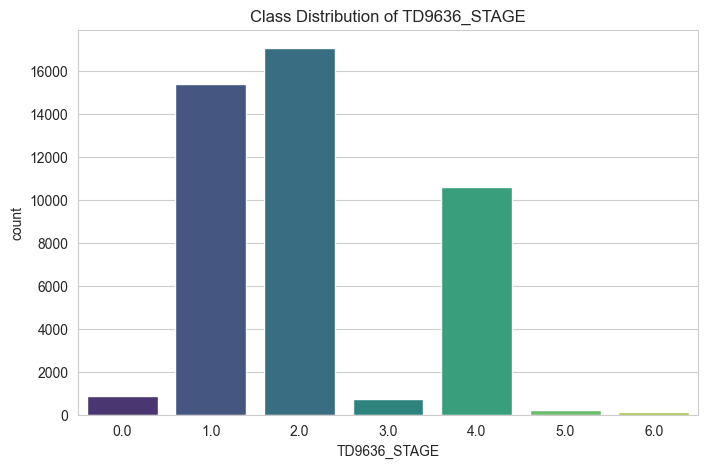

In [9]:

# Plot target variable distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df['TD9636_STAGE'], palette='viridis')
plt.title("Class Distribution of TD9636_STAGE")



In [10]:
plt.show()

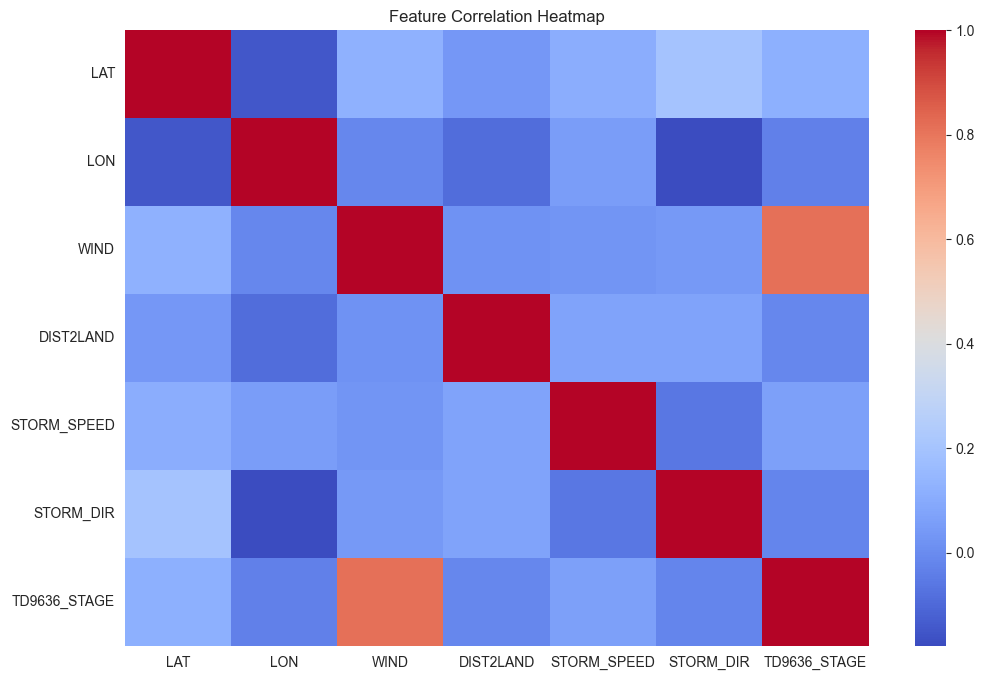

In [11]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])


# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")

plt.show()

In [12]:

# Convert categorical variables using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()


,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,2,3,4,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,2,3,4,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,2,3,4,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,2,3,4,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,2,3,4,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [13]:

# Define X and y
X = df.drop(columns=['TD9636_STAGE'])
y = df['TD9636_STAGE']

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [14]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [15]:

# Train multiple models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}



In [16]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

results


Random Forest Accuracy: 0.9692
Gradient Boosting Accuracy: 0.9200


C:\Users\FAVOUR\anaconda3\envs\exam\lib\site-packages\xgboost\core.py:158: UserWarning: [16:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9609


{'Random Forest': 0.9692191878215047,
 'Gradient Boosting': 0.9199949813893187,
 'XGBoost': 0.9608548366860441}

In [17]:

# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k=min(10, X.shape[1]))
X_selected = selector.fit_transform(X_resampled, y_resampled)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
selected_features


Index(['SEASON', 'BASIN', 'NATURE', 'LAT', 'LON', 'WIND', 'DIST2LAND',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object')

In [18]:

# Set the number of components dynamically to avoid errors
n_pca_components = min(10, X_resampled.shape[1])  # Ensures n_components <= n_features

pca = PCA(n_components=n_pca_components)
X_pca = pca.fit_transform(X_resampled)

# Explained variance ratio
pca.explained_variance_ratio_



array([9.60972336e-01, 2.21457980e-02, 1.50625669e-02, 1.08943770e-03,
       6.46597766e-04, 7.84149111e-05, 2.05809969e-06, 1.58000504e-06,
       1.21095770e-06])

In [19]:

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}




In [20]:
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters
grid_search_rf.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [21]:

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters
grid_search_xgb.best_params_


C:\Users\FAVOUR\anaconda3\envs\exam\lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}

In [23]:

# Evaluate the best Random Forest model
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3470
         1.0       0.95      0.93      0.94      3470
         2.0       0.91      0.92      0.91      3419
         3.0       0.97      0.99      0.98      3437
         4.0       0.97      0.95      0.96      3397
         5.0       0.99      1.00      1.00      3371
         6.0       1.00      1.00      1.00      3347

    accuracy                           0.97     23911
   macro avg       0.97      0.97      0.97     23911
weighted avg       0.97      0.97      0.97     23911



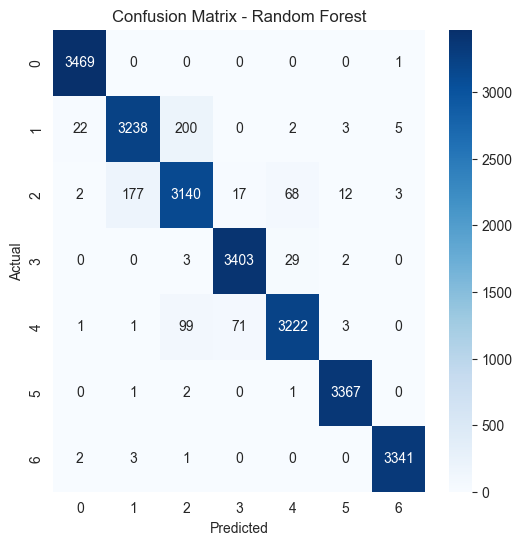

In [24]:

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


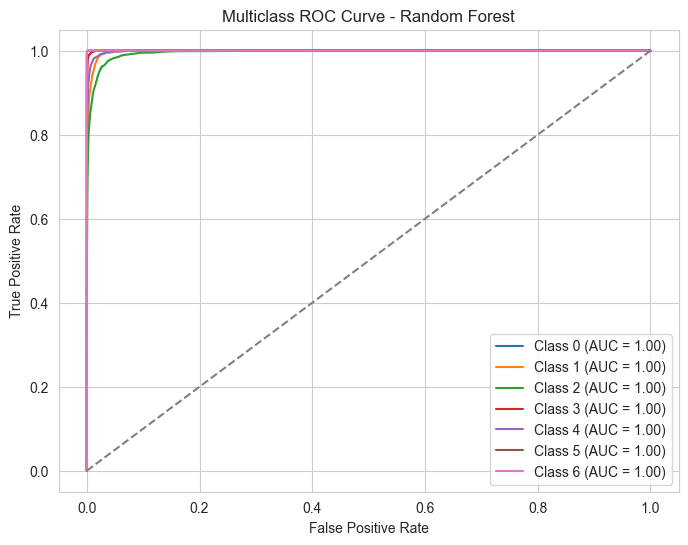

In [25]:

from sklearn.preprocessing import label_binarize

# Binarize the output (convert multiclass labels into binary format for ROC curve)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], best_rf.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Random Forest")
plt.legend()
plt.show()



In [26]:
train_accuracy = best_rf.score(X_train, y_train)
test_accuracy = best_rf.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

#checking for overfitting

Training Accuracy: 1.0000
Test Accuracy: 0.9694


In [27]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation accuracy: 0.9424 ± 0.0102


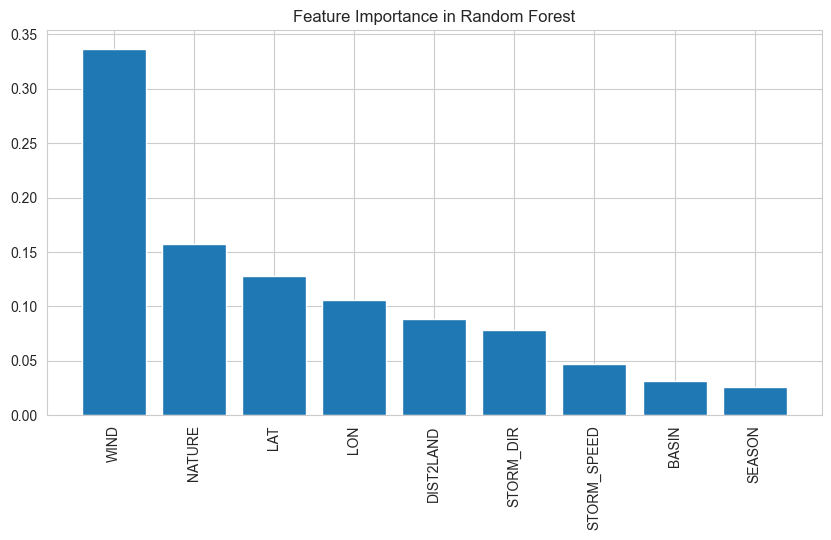

In [28]:
importances = best_rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()


In [29]:
correlation_matrix = df.corr()
print(correlation_matrix["TD9636_STAGE"].sort_values(ascending=False))

#If "WIND" is too strongly correlated with the target, it may be causing overfitting.

TD9636_STAGE    1.000000
WIND            0.812628
NATURE          0.171669
LAT             0.116189
STORM_SPEED     0.062077
BASIN           0.028339
DIST2LAND      -0.016103
STORM_DIR      -0.021992
LON            -0.032310
SEASON         -0.094001
Name: TD9636_STAGE, dtype: float64


In [30]:
X_new = X_resampled.drop(columns=['WIND'])  # Drop wind feature
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y_resampled, test_size=0.2, random_state=42)

best_rf.fit(X_train_new, y_train)
y_pred_new = best_rf.predict(X_test_new)

print(classification_report(y_test, y_pred_new))


#If accuracy remains high, the model was over-relying on "WIND".
#If accuracy drops drastically, "WIND" is genuinely important.

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3470
         1.0       0.89      0.85      0.87      3470
         2.0       0.86      0.83      0.84      3419
         3.0       0.95      0.98      0.96      3437
         4.0       0.88      0.90      0.89      3397
         5.0       0.99      1.00      1.00      3371
         6.0       1.00      1.00      1.00      3347

    accuracy                           0.94     23911
   macro avg       0.94      0.94      0.94     23911
weighted avg       0.94      0.94      0.94     23911



In [31]:
from sklearn.feature_selection import RFE

selector = RFE(best_rf, n_features_to_select=5, step=1)
selector.fit(X_resampled, y_resampled)

selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['NATURE', 'LAT', 'LON', 'WIND', 'DIST2LAND'], dtype='object')


In [32]:
#wind is important

In [33]:

import joblib

# Save the trained model
joblib.dump(best_rf, "random_forest_model.pkl")

print("Model saved successfully as random_forest_model.pkl")


Model saved successfully as random_forest_model.pkl
